# 第３回 認識技術特論 課題答案
## 23vr008n 三宅研 高林秀



# 課題内容

- 犬と猫のデータセット演習用 Jupyter Notebook ファイル
（TransferCNN.ipynb）をまねて学習済み VGG19、ResNet などのモデルのファ
インチューニングをすることで犬と猫のデータセットを認識する code を作成
してください。
- 学習用データの水増しがありとなしを用いるとき学習した犬と
猫の認識モデルにおいて、テスト用（val フォールダーの中の画像）データの
認識結果を比較してください。

1. Jupyter Notebook で作成し、それぞれのコードについて簡単な説明を加え
てください
2. 一部の画像と認識ラベルを表示してください。
3. 考察や自分の考え方を簡単に纏めてください。

# 解答コード

In [3]:
# 共通モジュールのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
from tqdm import tqdm
from enum import Enum

In [4]:
# データセットの準備
class DataKeys(Enum):
    TRAIN = "train"
    VALID = "val"
    TEST = "test"

DATA_DIR = "./DogCat"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VALID_DIR = os.path.join(DATA_DIR, "val")

# 画像データの前処理
data_transfroms = { 
    DataKeys.TRAIN: transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor() #テンソルへの変換
    ]),
    DataKeys.VALID: transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

datasets = {
    DataKeys.TRAIN: datasets.ImageFolder(TRAIN_DIR, transform=data_transfroms[DataKeys.TRAIN]),
    DataKeys.TEST: datasets.ImageFolder(VALID_DIR, transform=data_transfroms[DataKeys.VALID])
}

# 訓練データを訓練用と検証用に分割
train_size = int(0.8 * len(datasets[DataKeys.TRAIN]))
val_size = len(datasets[DataKeys.TRAIN]) - train_size
train_dataset, val_dataset = random_split(datasets[DataKeys.TRAIN], [train_size, val_size])

dataloaders = {
    DataKeys.TRAIN: DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    DataKeys.VALID: DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4),
    DataKeys.TEST: DataLoader(datasets[DataKeys.TEST], batch_size=32, shuffle=False, num_workers=4),
}





In [5]:
# データセットの確認

dataset_sizes = {x: len(dataloaders[x].dataset) for x in [DataKeys.TRAIN, DataKeys.VALID, DataKeys.TEST]}
class_names = datasets[DataKeys.TRAIN].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Dataset size: {dataset_sizes}")
print(f"Train Class names: {class_names}")
print(f"Test Class names:{datasets[DataKeys.TEST].classes}")
print(f"Learning Device: {device}")


Dataset size: {<DataKeys.TRAIN: 'train'>: 1760, <DataKeys.VALID: 'val'>: 440, <DataKeys.TEST: 'test'>: 544}
Train Class names: ['Cat', 'Dog']
Test Class names:['Cat', 'Dog']
Learning Device: cuda:0


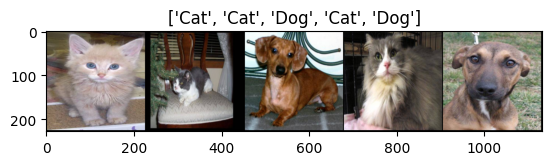

In [6]:
# ランダムに5枚の画像を表示する関数
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))  # CPUテンソルに変換してからNumpy配列に変換
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # プロットが更新されるのを一時停止

# ランダムに5枚の画像を表示
def show_random_images(dataloader):
    inputs, classes = next(iter(dataloader))
    out = utils.make_grid(inputs[:5])
    imshow(out, title=[class_names[x] for x in classes[:5]])
    plt.show()

# 訓練データ中任意の5枚を表示
show_random_images(dataloaders[DataKeys.TRAIN])

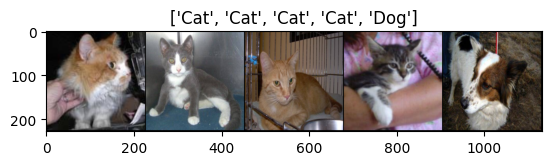

In [7]:
# 検証データ中任意の5枚を表示
show_random_images(dataloaders[DataKeys.VALID])

In [8]:
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


def plot_learning_curves(train_losses, val_accuracies):
    """学習曲線（損失と精度）をプロットする関数"""
    plt.figure(figsize=(12, 6))
    
    # 訓練損失のプロット
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 検証精度のプロット
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [9]:
def train_model(model, dataloaders, learning_rates, num_epochs):
    best_accuracy = 0
    best_history = None

    for lr in learning_rates:
        print(f"Training with LR={lr}")

        # 損失関数とオプティマイザー
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # 訓練と検証の履歴を保存するリスト
        train_losses = []
        val_accuracies = []

        # 訓練ループ
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            for inputs, labels in tqdm(dataloaders[DataKeys.TRAIN], desc="training..."):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            avg_train_loss = train_loss / len(dataloaders[DataKeys.TRAIN])
            train_losses.append(avg_train_loss)

            accuracy = calculate_accuracy(model, dataloaders[DataKeys.VALID])
            val_accuracies.append(accuracy)

            print(f"Epoch {epoch+1}: Loss = {avg_train_loss:.4f}, Accuracy = {accuracy:.4f}%")

            # 最良のモデルを更新
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_history = {
                    "train_losses": train_losses,
                    "val_accuracies": val_accuracies,
                    "lr": lr,
                }
                torch.save(model.state_dict(), "best_model.pth")

    return best_history

In [10]:
# テスト用関数
def test_model(model, criterion, dataloader):
    model.eval()  # モデルを評価モードに設定

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    loss = running_loss / dataset_sizes[DataKeys.TEST]
    acc = running_corrects.double() / dataset_sizes[DataKeys.TEST]

    print(f'Test Loss: {loss:.4f} Acc: {acc:.4f}')

## 学習データの水増し無しのパターン

In [11]:
# モデルの準備
# モデルの訓練と評価を実行
learning_rates = [0.0001, 0.00001]
num_epochs = 20
CLASS_SIZE = len(class_names)

model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, CLASS_SIZE)
model = model.to(device)

best_history = train_model(model, dataloaders, learning_rates, num_epochs)

Training with LR=0.0001


training...: 100%|██████████| 55/55 [03:17<00:00,  3.58s/it]


Epoch 1: Loss = 0.1452, Accuracy = 97.5000%


training...:  11%|█         | 6/55 [00:33<04:33,  5.58s/it]


KeyboardInterrupt: 

## 学習データの水増しありのパターン

## 両パターンの比較と考察